In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from pprint import pprint
from skimage.io import imread
from torch.utils.data import DataLoader
import utils
from models import HumerusDataset, Rescale, NoneTransform, BaselineNN
import torch
from torch import nn
import torchvision
print(f'Pytorch version: {torch.__version__}, Torchvision version: {torchvision.__version__}')

Pytorch version: 2.0.0+cpu, Torchvision version: 0.15.1+cpu


In [2]:
path=glob.glob(os.path.join('MURA-v1.1','*','*','*', '*','*.png'))
pprint(path)


['MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image3.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00016\\study1_positive\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00016\\study1_positive\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00016\\study1_positive\\image3.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00026\\study1_negative\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00026\\study1_negative\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00026\\study1_negative\\image3.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00031\\study1_negative\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00031\\study1_negative\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00034\\study1_positive\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00034\\study1_positive\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient0

We try to concatenate all the info about the images in one dataset
We use the character '\\' because one '\' is the escape and the other separates the subfolders in our OS (Windows). if we worked in linux we would use the character '/'
THere are two studies :study 1 and study 2

In [3]:
everythingScans_df=pd.DataFrame(dict(path=path))
everythingScans_df['Split']=everythingScans_df['path'].map(lambda x:x.split('\\')[1])
everythingScans_df['Bone']=everythingScans_df['path'].map(lambda x:x.split('\\')[2])
everythingScans_df['Patient']=everythingScans_df['path'].map(lambda x:x.split('\\')[3])
everythingScans_df['FolderName']=everythingScans_df['path'].map(lambda x:x.split('\\')[4])
everythingScans_df['Study']=everythingScans_df['path'].map(lambda x:x.split('\\')[4].split('_')[0])
everythingScans_df['Label']=everythingScans_df['path'].map(lambda x:x.split('\\')[4].split('_')[1])
everythingScans_df.sample(10)

path  Split         Bone  \
17147  MURA-v1.1\train\XR_HAND\patient11089\study1_ne...  train      XR_HAND   
28345  MURA-v1.1\train\XR_WRIST\patient04491\study1_n...  train     XR_WRIST   
23835  MURA-v1.1\train\XR_SHOULDER\patient01677\study...  train  XR_SHOULDER   
7970   MURA-v1.1\train\XR_FINGER\patient04081\study1_...  train    XR_FINGER   
7818   MURA-v1.1\train\XR_FINGER\patient04026\study1_...  train    XR_FINGER   
22165  MURA-v1.1\train\XR_SHOULDER\patient01126\study...  train  XR_SHOULDER   
33697  MURA-v1.1\train\XR_WRIST\patient08055\study1_n...  train     XR_WRIST   
18535  MURA-v1.1\train\XR_HUMERUS\patient03156\study1...  train   XR_HUMERUS   
15993  MURA-v1.1\train\XR_HAND\patient10673\study1_ne...  train      XR_HAND   
37643  MURA-v1.1\valid\XR_FINGER\patient11931\study1_...  valid    XR_FINGER   

            Patient       FolderName   Study     Label  
17147  patient11089  study1_negative  study1  negative  
28345  patient04491  study1_negative  study1  negative  
23835  patient01677  study1_negative  study1  negative  
7970   patient04081  study1_negative  study1  negative  
7818   patient04026  study1_negative  study1  negative  
22165  patient01126  study2_positive  study2  positive  
33697  patient08055  study1_negative  study1  negative  
18535  patient03156  study1_negative  study1  negative  
15993  patient10673  study1_negative  study1  negative  
37643  patient11931  study1_negative  study1  negative

We check if some data is missing

In [4]:
print(everythingScans_df.isnull().values.any())
a=[0 if (x=='positive' or x=='negative') else 1 for x in everythingScans_df['Label'] ]
print(sum(a))

False
0


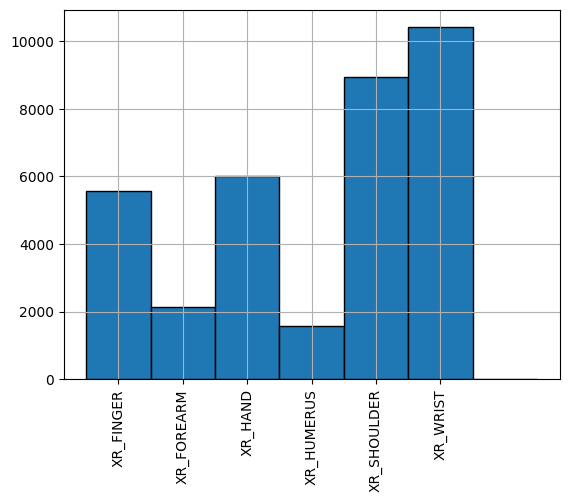

In [5]:

everythingScans_df['Bone'].hist(bins=range(1,9),rwidth=1, align='left',edgecolor='black')
plt.xticks(rotation=90)
plt.show()

# Explore some examples of images
When groupping by two values we need to define how the values will be combined.
get combinations of pics with same label and bone then choose one randomly 

In [6]:
onePairPic_df=everythingScans_df.groupby(['Label','Bone']).apply(lambda x:x.sample(1))
onePairPic_df.reset_index(drop=True)

path  Split         Bone  \
0   MURA-v1.1\train\XR_ELBOW\patient05997\study1_n...  train     XR_ELBOW   
1   MURA-v1.1\train\XR_FINGER\patient04777\study1_...  train    XR_FINGER   
2   MURA-v1.1\train\XR_FOREARM\patient09527\study1...  train   XR_FOREARM   
3   MURA-v1.1\train\XR_HAND\patient10889\study1_ne...  train      XR_HAND   
4   MURA-v1.1\train\XR_HUMERUS\patient02995\study1...  train   XR_HUMERUS   
5   MURA-v1.1\train\XR_SHOULDER\patient01912\study...  train  XR_SHOULDER   
6   MURA-v1.1\train\XR_WRIST\patient08809\study1_n...  train     XR_WRIST   
7   MURA-v1.1\train\XR_ELBOW\patient01624\study1_p...  train     XR_ELBOW   
8   MURA-v1.1\valid\XR_FINGER\patient11892\study1_...  valid    XR_FINGER   
9   MURA-v1.1\train\XR_FOREARM\patient00687\study1...  train   XR_FOREARM   
10  MURA-v1.1\train\XR_HAND\patient10106\study1_po...  train      XR_HAND   
11  MURA-v1.1\train\XR_HUMERUS\patient02786\study1...  train   XR_HUMERUS   
12  MURA-v1.1\train\XR_SHOULDER\patient01356\study...  train  XR_SHOULDER   
13  MURA-v1.1\valid\XR_WRIST\patient11216\study1_p...  valid     XR_WRIST   

         Patient       FolderName   Study     Label  
0   patient05997  study1_negative  study1  negative  
1   patient04777  study1_negative  study1  negative  
2   patient09527  study1_negative  study1  negative  
3   patient10889  study1_negative  study1  negative  
4   patient02995  study1_negative  study1  negative  
5   patient01912  study1_negative  study1  negative  
6   patient08809  study1_negative  study1  negative  
7   patient01624  study1_positive  study1  positive  
8   patient11892  study1_positive  study1  positive  
9   patient00687  study1_positive  study1  positive  
10  patient10106  study1_positive  study1  positive  
11  patient02786  study1_positive  study1  positive  
12  patient01356  study1_positive  study1  positive  
13  patient11216  study1_positive  study1  positive

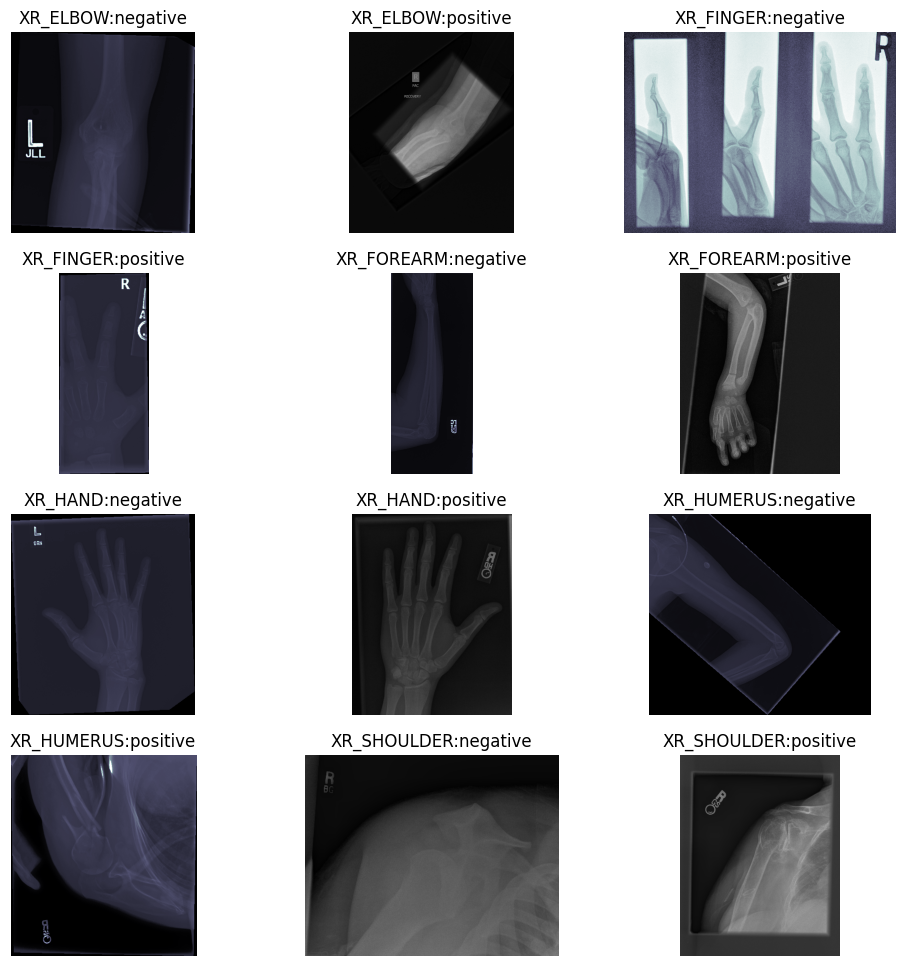

In [7]:
sub_df = everythingScans_df.groupby(['Bone', 'Label']).apply(lambda x: x.sample(1)).reset_index(drop = True)
fig, (m_axs) = plt.subplots(4, sub_df.shape[0]//4, figsize = (12, 12))
for c_ax, (_, c_row) in zip(m_axs.flatten(), sub_df.iterrows()):
    c_ax.imshow(imread(c_row['path']), cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title('{Bone}:{Label}'.format(**c_row))

In [8]:
# try working only on humerus

humerus_df=everythingScans_df.loc[everythingScans_df['Bone']=='XR_HUMERUS'].copy()
humerus_df.sample(10)

path  Split        Bone  \
18422  MURA-v1.1\train\XR_HUMERUS\patient03104\study1...  train  XR_HUMERUS   
17892  MURA-v1.1\train\XR_HUMERUS\patient02858\study1...  train  XR_HUMERUS   
17670  MURA-v1.1\train\XR_HUMERUS\patient02757\study1...  train  XR_HUMERUS   
18342  MURA-v1.1\train\XR_HUMERUS\patient03065\study1...  train  XR_HUMERUS   
38526  MURA-v1.1\valid\XR_HUMERUS\patient11313\study1...  valid  XR_HUMERUS   
18528  MURA-v1.1\train\XR_HUMERUS\patient03152\study1...  train  XR_HUMERUS   
18612  MURA-v1.1\train\XR_HUMERUS\patient03193\study1...  train  XR_HUMERUS   
18154  MURA-v1.1\train\XR_HUMERUS\patient02976\study1...  train  XR_HUMERUS   
38681  MURA-v1.1\valid\XR_HUMERUS\patient11659\study1...  valid  XR_HUMERUS   
18210  MURA-v1.1\train\XR_HUMERUS\patient03002\study1...  train  XR_HUMERUS   

            Patient       FolderName   Study     Label  
18422  patient03104  study1_negative  study1  negative  
17892  patient02858  study1_positive  study1  positive  
17670  patient02757  study1_positive  study1  positive  
18342  patient03065  study1_negative  study1  negative  
38526  patient11313  study1_positive  study1  positive  
18528  patient03152  study1_negative  study1  negative  
18612  patient03193  study1_negative  study1  negative  
18154  patient02976  study1_negative  study1  negative  
38681  patient11659  study1_positive  study1  positive  
18210  patient03002  study1_negative  study1  negative

c:\Users\pchrk\OneDrive\Desktop\pms cs\NLP\NLP\nlp_venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
torch.Size([3, 256, 256]) 0
<class 'torch.Tensor'>


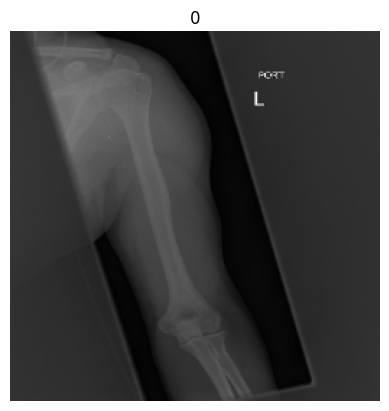

In [9]:
#DO NOT add transforms.ToTensor() to the transform list!
data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256,256])
])

img, label = HumerusDataset(humerus_df,data_transforms).__getitem__(5)
#shape attributed evaluated at runtime depending on the dataset implementation

print(img.shape, label)
print(type(img))
utils.show_image_w_label(img, label)

In [10]:
BATCH_SIZE=32
transormation=torchvision.transforms.Compose([
    torchvision.transforms.Resize([256,256]),
])

train_dataloader=DataLoader(HumerusDataset(humerus_df.loc[humerus_df['Split']=='train'].copy(),transform=transormation), batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader=DataLoader(HumerusDataset(humerus_df.loc[humerus_df['Split']=='valid'].copy(),transform=transormation), batch_size=BATCH_SIZE, shuffle=True)


# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, valid_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(valid_dataloader)} batches of {BATCH_SIZE}")

# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x0000023F1B51E980>, <torch.utils.data.dataloader.DataLoader object at 0x0000023F1B51CD30>)
Length of train dataloader: 40 batches of 32
Length of test dataloader: 9 batches of 32
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: ()

c:\Users\pchrk\OneDrive\Desktop\pms cs\NLP\NLP\nlp_venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256,

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

In [11]:
def train(model, dataloader, loss_fn, optimizer, num_epochs=5):

    #put in training mode
    model.train()
    #reset model parameters
    model.reset_parameters()


    loss_history=[]
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for i, (inputs, labels) in enumerate(dataloader):
            #inputs=inputs.view(inputs.shape[0],-1)
            outputs=model(inputs)
            print(outputs.shape,outputs.dtype)
            print(labels.shape,labels.dtype)
            labels=labels.type_as(outputs)
            loss=loss_fn(outputs,labels)
            optimizer.zero_grad()


            #update parameters
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            
            optimizer.step()


            if i%10==0:
                print(f"Loss at iteration {i} is {loss.item()}")
                loss_history.append(loss.item())
    return loss_history
    
@torch.no_grad()    
def evaluate(model, dataloader, loss_fn):
    model.eval()

    loss_history=[]
    
    for i, (inputs, labels) in enumerate(dataloader):
        inputs=inputs.view(inputs.shape[0],-1)
        outputs=model(inputs)
        loss=loss_fn(outputs,labels)
        loss_history.append(loss.item())
    return loss_history

In [12]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
## explain why train_features_batch does not have the correct dimensions when applying shape????

img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256,

In [13]:
input_size = 3*train_features_batch.shape[2]*train_features_batch.shape[3]
print(f"Input size: {input_size}")
loss_fn=torch.nn.BCELoss()
model=BaselineNN(input_size=input_size, hidden_size=128, output_size=1)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

train_loss_history=train(model, train_dataloader, loss_fn, optimizer, num_epochs=5)
valid_loss_history=evaluate(model, valid_dataloader, loss_fn)




Input size: 196608
Epoch 1/5
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
img shape: torch.Size([3, 256, 256]) img dtype: torch.float32
label shape: () label dtype: int64
i

In [ ]:
input_size = 3*train_features_batch.shape[2]*train_features_batch.shape[3]
print(f"Input size: {input_size}")
loss_fn=torch.nn.BCELoss()
model=BaselineNN(input_size,128,1)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
input=next(iter(train_dataloader))[0]
print(input.shape)
model(input)


Input size: 196608
torch.Size([32, 3, 256, 256])
pre flatten layer: torch.Size([32, 3, 256, 256]) torch.uint8
post flatten layer: torch.Size([32, 196608]) torch.uint8


RuntimeError: mat1 and mat2 must have the same dtype